```bash
# create virtual environment
python -m venv venv

# activate it
source venv/bin/activate   # Mac/Linux
venv\Scripts\activate      # Windows

# install dependencies
pip install -r requirements.txt

# register jupyter env
python -m ipykernel install --user --name=caltech-venv --display-name "Caltech101 venv"
```

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import math

class BaseClassifier(nn.Module):

    def __init__(self, criterion=None, lr=1e-3, weight_decay=0):
        super().__init__()

        self.model = self.build_model()
        
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def train_one_epoch(self, loader):

        self.model.train()
        total_loss = 0
        total_correct = 0

        for X, Y in loader:
            
            X, Y = X.to(self.device), Y.to(self.device)

            outputs = self.model(X)
            loss = self.criterion(outputs, Y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * X.size(0)
            total_correct += outputs.argmax(1).eq(Y).sum().item()

        return total_loss / len(loader.dataset), total_correct / len(loader.dataset)
    
    def evaluate(self, loader):

        self.model.eval()
        total_loss = 0
        total_correct = 0

        with torch.no_grad():
            for X, Y in loader:
                X, Y = X.to(self.device), Y.to(self.device)

                outputs = self.model(X)
                loss = self.criterion(outputs, Y)

                total_loss += loss.item() * X.size(0)
                total_correct += outputs.argmax(1).eq(Y).sum().item()

        return total_loss / len(loader.dataset), total_correct / len(loader.dataset)
    
    def fit(self, train_loader, test_loader, epochs, writer):

        train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
        
        for epoch in tqdm(range(epochs), unit="epoch", colour="green"):
            train_loss, train_acc = self.train_one_epoch(train_loader)
            test_loss, test_acc = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            writer.add_scalars("Loss", {"train": train_loss, "test": test_loss}, epoch)
            writer.add_scalars("Accuracy", {"train": train_acc, "test": test_acc}, epoch)

            if epoch % 5 == 0:
                self.log_misclassified(test_loader, writer, epoch)
                
            # print(f"Epoch {epoch+1}/{epochs} "
            #       f"| Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
            #       f"| Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

        # Final log
        if epoch % 5 != 0:
            self.log_misclassified(test_loader, writer, epoch)

        return (train_losses, test_losses, train_accuracies, test_accuracies)

    def log_misclassified(self, dataloader, writer, epoch):

        self.model.eval()

        misclassified = []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(self.device)
                outputs = self.model(images)
                preds = outputs.argmax(1)
                mask = preds != labels

                if mask.any():
                    misclassified.append(images[mask].cpu())

        if len(misclassified) == 0:
            return

        # Concatenate all batches
        misclassified = torch.cat(misclassified, dim=0)

        num_images = misclassified.shape[0]

        # Make image grid
        img_grid = make_grid(misclassified, nrow=math.ceil(math.sqrt(num_images)), normalize=True)

        writer.add_image(f"Predictions/misclassified", img_grid, epoch)
            
    def build_model(self):
        raise NotImplementedError("")

In [2]:
import matplotlib.pyplot as plt

def plot_training(metrics):

    train_losses, test_losses, train_accs, test_accs = metrics

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # ---------------- LOSS ----------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # ---------------- ACCURACY ----------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, test_accs, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder("Caltech_101/", transform=transform)

In [4]:
import random
from torch.utils.data import Subset
from torch.utils.data import DataLoader

# Mapping: class_index -> list of indices belonging to that class
class_to_indices = {i: [] for i in range(len(dataset.classes))}
for idx, (_, label) in enumerate(dataset):
    class_to_indices[label].append(idx)

train_indices = []
test_indices = []

for label, indices in class_to_indices.items():
    random.shuffle(indices)
    train_indices.extend(indices[:15])
    test_indices.extend(indices[15:30])  # next 15

train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

First, simple CNN based on LeNet (course)

In [5]:
# LeNet
class SimpleCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

  0%|          | 0/20 [00:00<?, ?epoch/s]

100%|██████████| 20/20 [01:15<00:00,  3.79s/epoch]


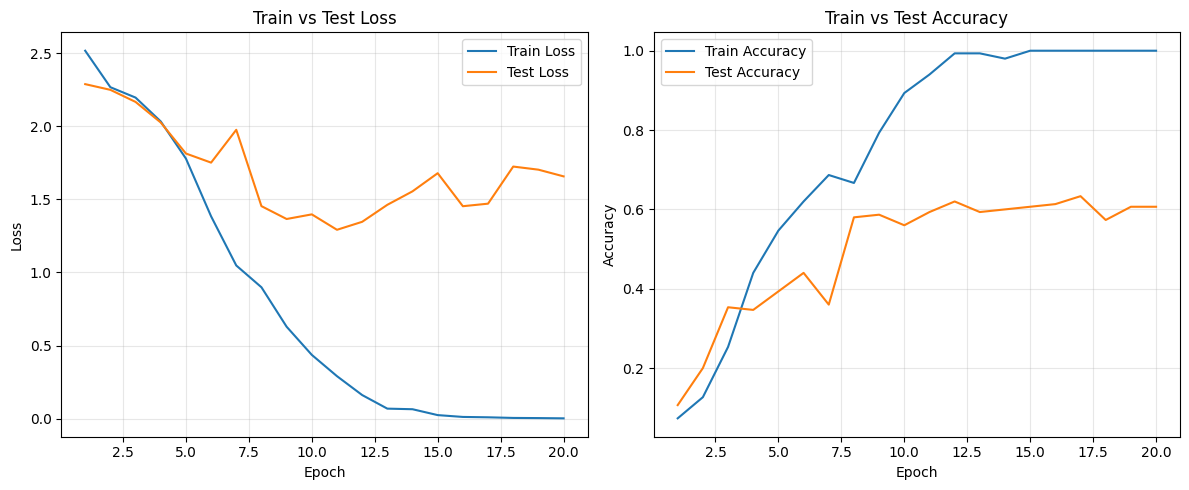

In [6]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/SimpleCNN")

simple_cnn = SimpleCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

```bash
# Training logs
tensorboard --logdir runs/SimpleCNN
```

___

Deeper network (Add 1 Conv layer and 1 Dense layer)

In [7]:
class DeeperCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 32, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(18432, 200), nn.ReLU(),
            nn.Linear(200, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

  0%|          | 0/30 [00:00<?, ?epoch/s]

100%|██████████| 30/30 [01:43<00:00,  3.46s/epoch]


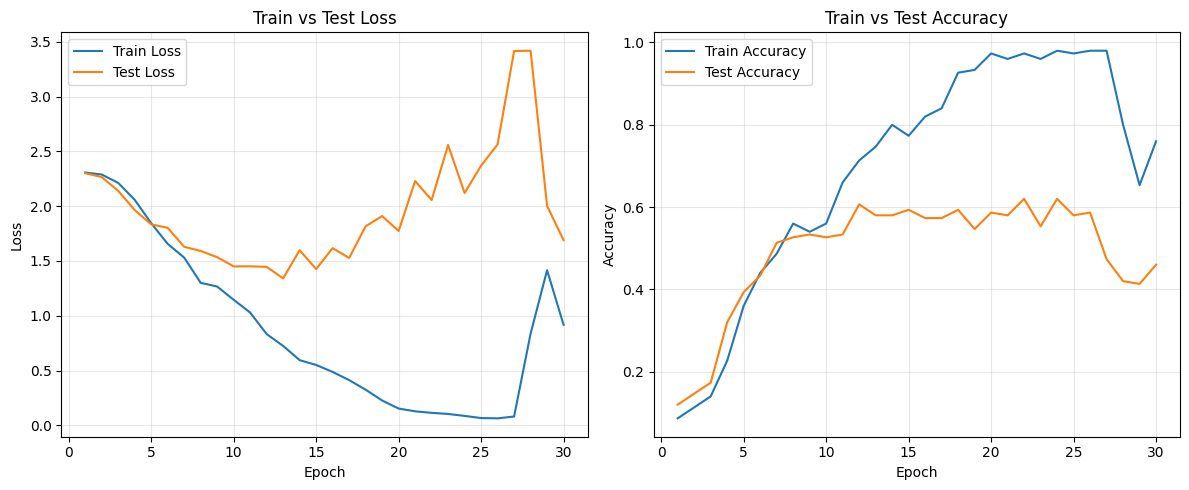

In [8]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/DeeperCNN")

simple_cnn = DeeperCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

-> Longer to train, does not improve the test accuracy

___

Use strided convolutions instead of max pooling

In [9]:
class StridedCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5), stride=2), nn.ReLU(),
            nn.Conv2d(6, 16, (5,5), stride=2), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

  0%|          | 0/20 [00:00<?, ?epoch/s]

100%|██████████| 20/20 [00:38<00:00,  1.93s/epoch]


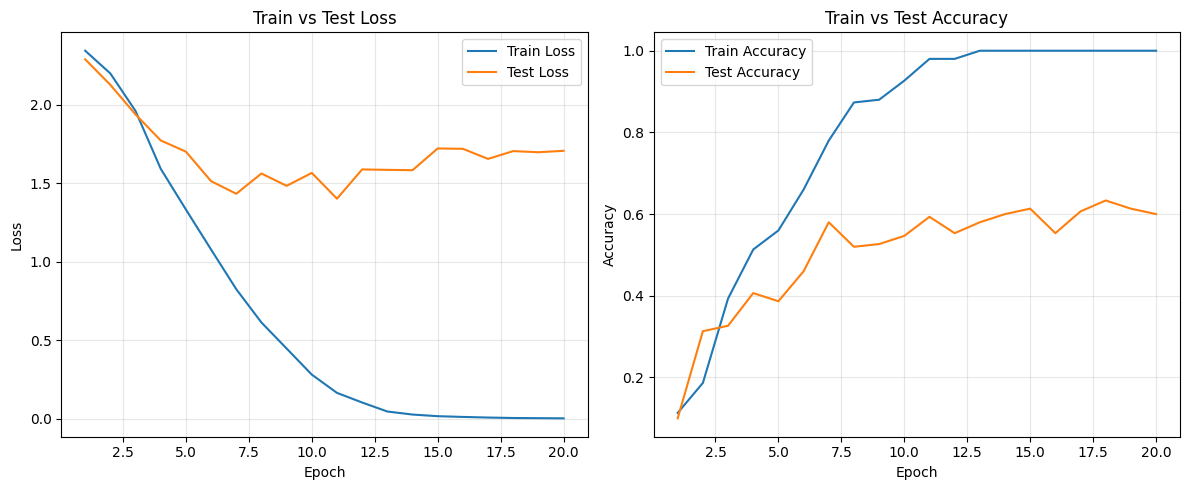

In [10]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/StridedCNN")

simple_cnn = StridedCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

-> Similar with the base one, maybe slightly worse

___

Reduce the filter size -> Preserve more locality information

In [11]:
class SmallKernelCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(46656, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 20/20 [01:03<00:00,  3.17s/epoch]


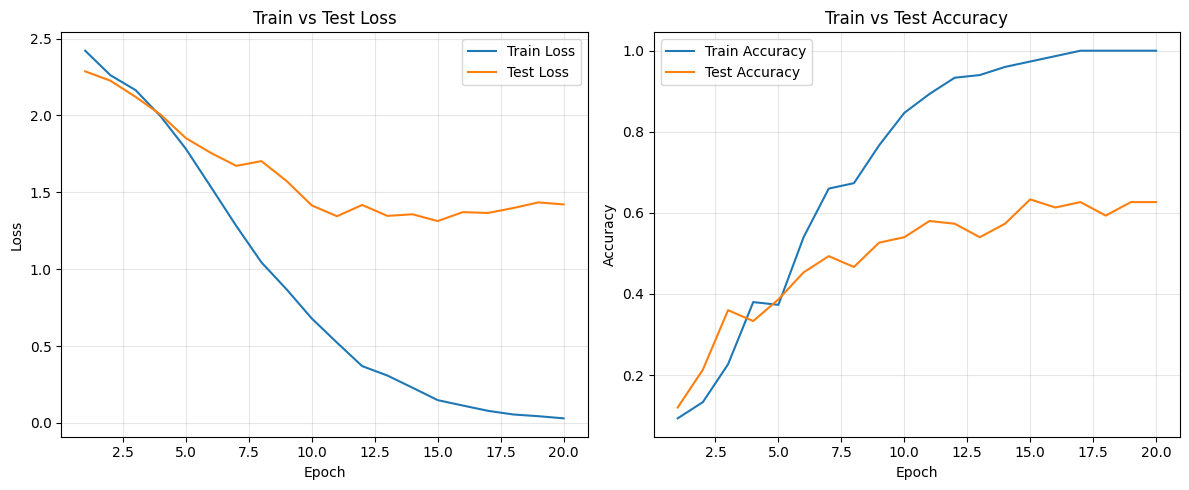

In [12]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/SmallKernelCNN")

simple_cnn = SmallKernelCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

___

Small kernel size but deeper

In [13]:
class SmallKernelDeepCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 12, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(12, 24, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(24, 48, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(6912, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 30/30 [01:31<00:00,  3.04s/epoch]


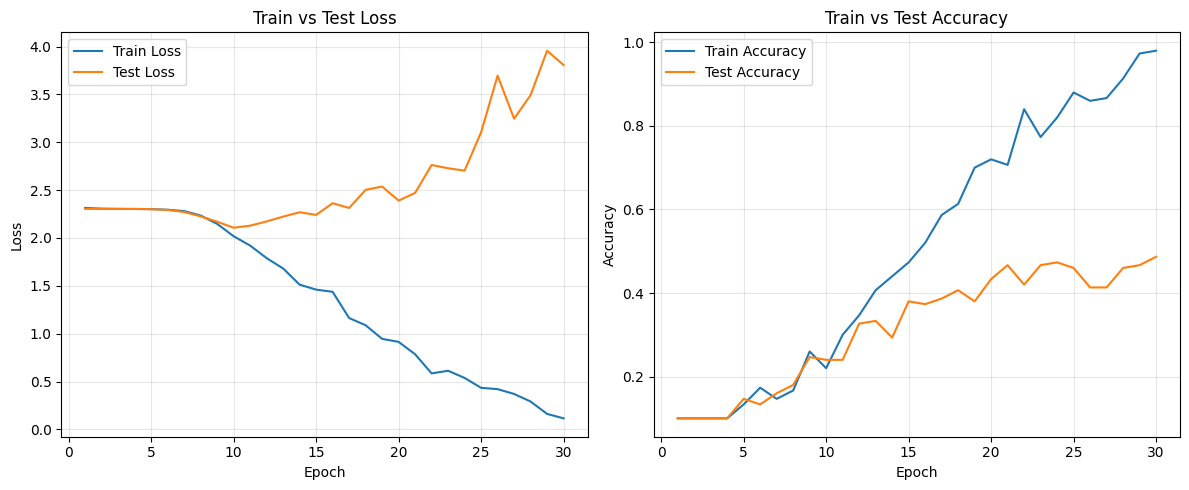

In [14]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/SmallKernelDeepCNN")

classifier = SmallKernelDeepCNN()
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

___

Skipping Connections

In [15]:
class BasicResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv(x)
        identity = self.projection(x)
        out += identity

        return self.relu(out)

class ResidualCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            BasicResidualBlock(3, 8),
            nn.MaxPool2d((2,2)),
            BasicResidualBlock(8, 16),
            nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(50176, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 30/30 [03:20<00:00,  6.68s/epoch]


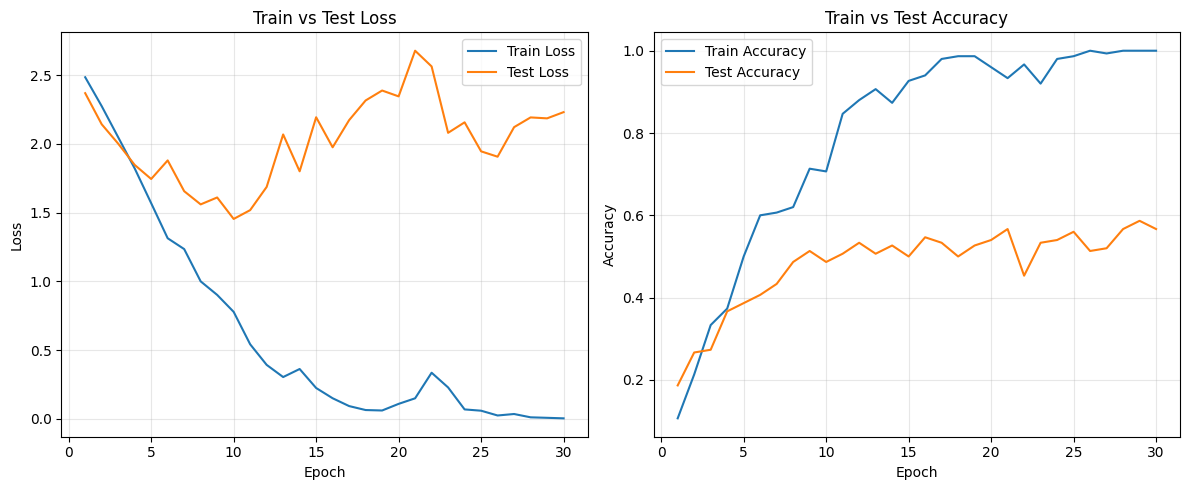

In [16]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/ResidualCNN")

classifier = ResidualCNN()
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

___

Batch Normalization (2D -> One per channel / 1D for Dense Layers)

In [17]:
class BatchNormCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), 
            nn.BatchNorm2d(6),
            nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (5,5)), 
            nn.BatchNorm2d(16),
            nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), 
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 84), 
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 30/30 [01:44<00:00,  3.47s/epoch]


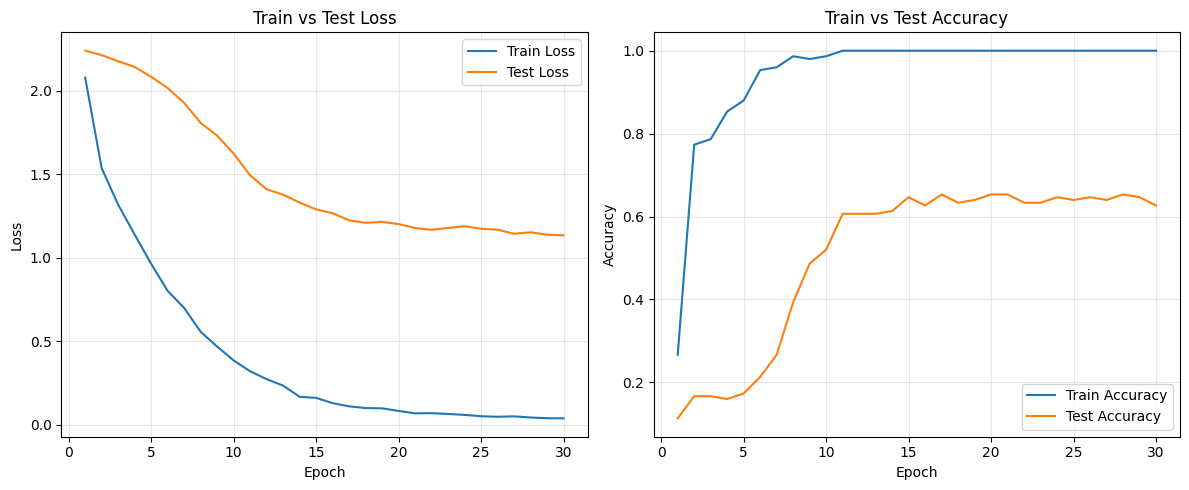

In [18]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/BatchNormCNN")

classifier = BatchNormCNN()
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

- The test loss doesn't increase anymore !
- Better asymptotoc accuracy
- Faster training

___

Layer Normalization (Across channels and spatial dimensions)

In [19]:
class LayerNormCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), 
            nn.LayerNorm([6, 220, 220]),
            nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (5,5)), 
            nn.LayerNorm([16, 106, 106]),
            nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), 
            nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84), 
            nn.LayerNorm(84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 30/30 [02:02<00:00,  4.10s/epoch]


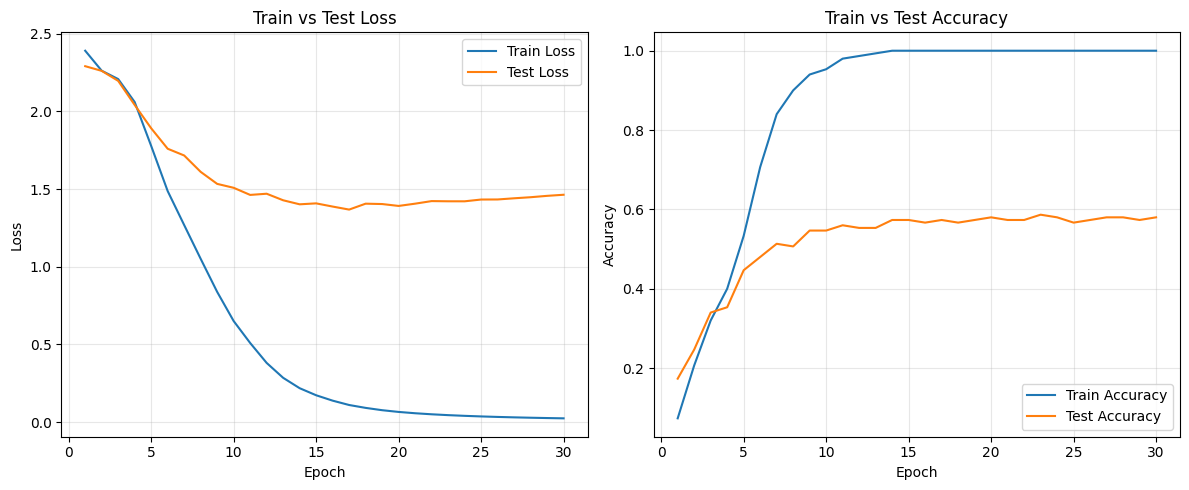

In [20]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/LayerNormCNN")

classifier = LayerNormCNN()
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Quite similar with Batch Norm

___

Instance Normalization (Normalize across spatial dimensions, one per channel)

In [21]:
class InstanceNormCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0):
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), 
            nn.InstanceNorm2d(6, affine=True),
            nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (5,5)), 
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), 
            nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84), 
            nn.LayerNorm(84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

  0%|          | 0/30 [00:00<?, ?epoch/s]

100%|██████████| 30/30 [01:46<00:00,  3.54s/epoch]


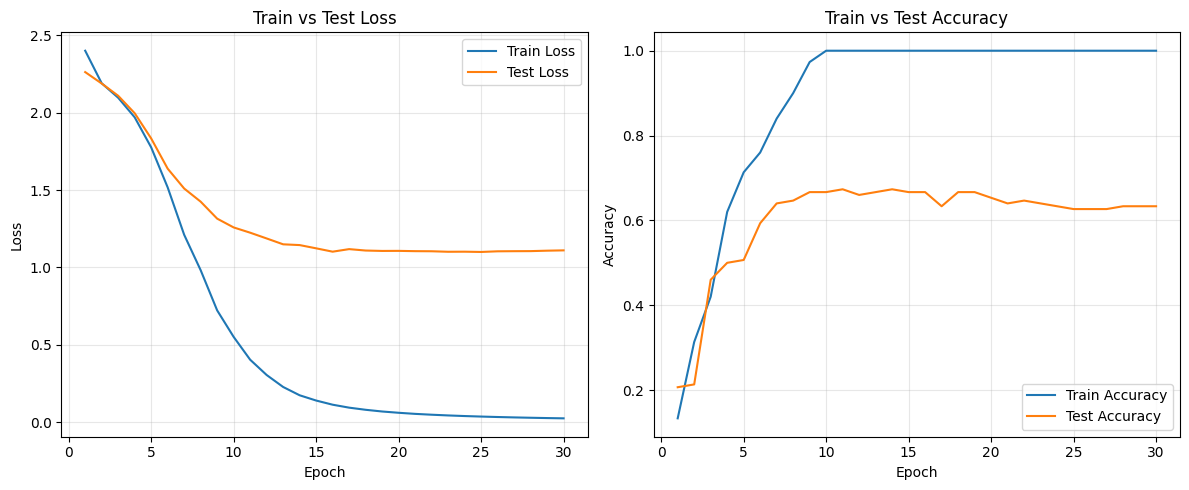

In [22]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/InstanceNormCNN")

classifier = InstanceNormCNN()
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

___

Weight Decay with different L2 penalty magnitudes

1. $\lambda=1$

100%|██████████| 20/20 [01:10<00:00,  3.52s/epoch]


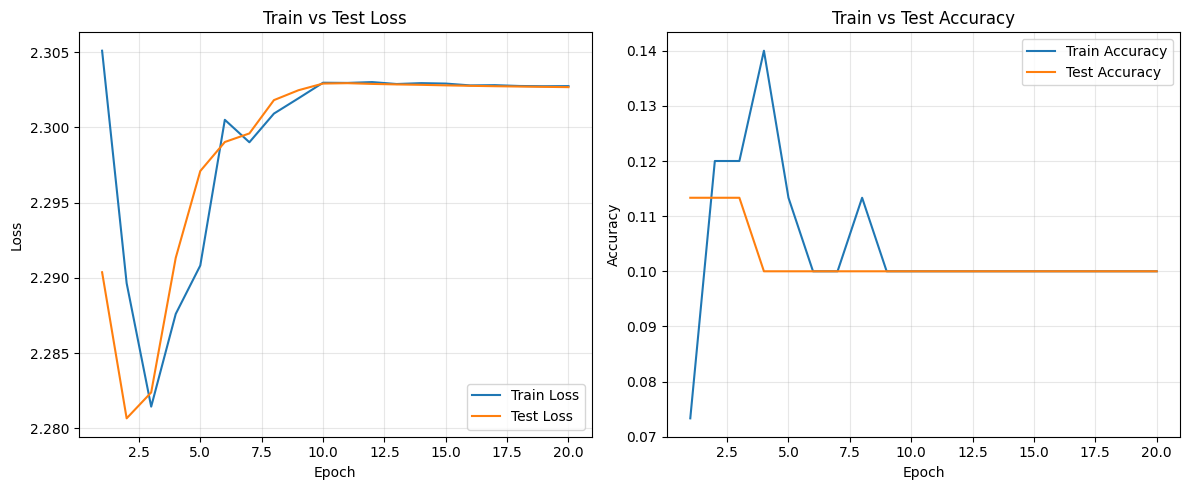

In [23]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/WeightDecay_0_CNN")

simple_cnn = SimpleCNN(weight_decay=1)
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

No training -> Accuracy 10% = Pure random classifier (weights shrunk to zero because the train and test loss are the same (misclassification loss))

2. $\lambda=0.1$

100%|██████████| 50/50 [02:45<00:00,  3.30s/epoch]


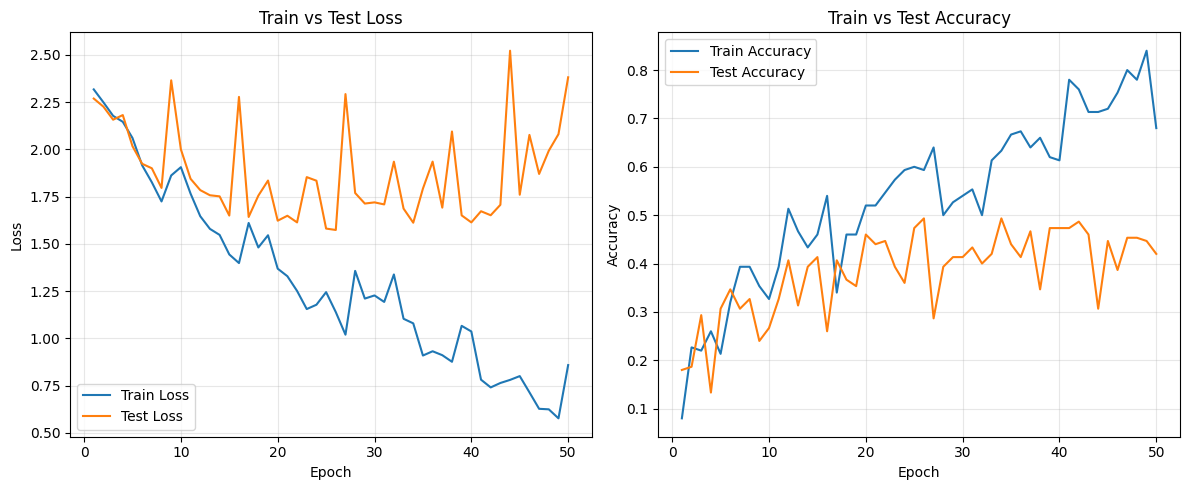

In [24]:
EPOCHS = 50
writer = SummaryWriter(log_dir=f"runs/WeightDecay_-1_CNN")

simple_cnn = SimpleCNN(weight_decay=0.1)
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Training is considerably longer, and still underfitting

3. $\lambda=0.01$

100%|██████████| 50/50 [02:40<00:00,  3.20s/epoch]


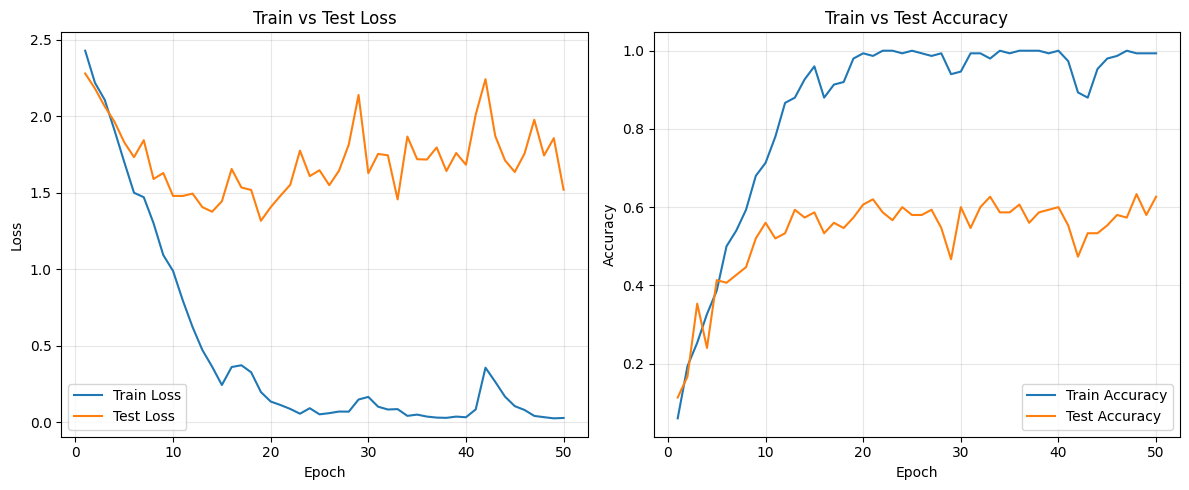

In [25]:
EPOCHS = 50
writer = SummaryWriter(log_dir=f"runs/WeightDecay_-2_CNN")

simple_cnn = SimpleCNN(weight_decay=0.01)
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Not underfitting, but the regularization effect is slight -> Should use bigger value

4. $\lambda=0.05$

100%|██████████| 50/50 [02:39<00:00,  3.19s/epoch]


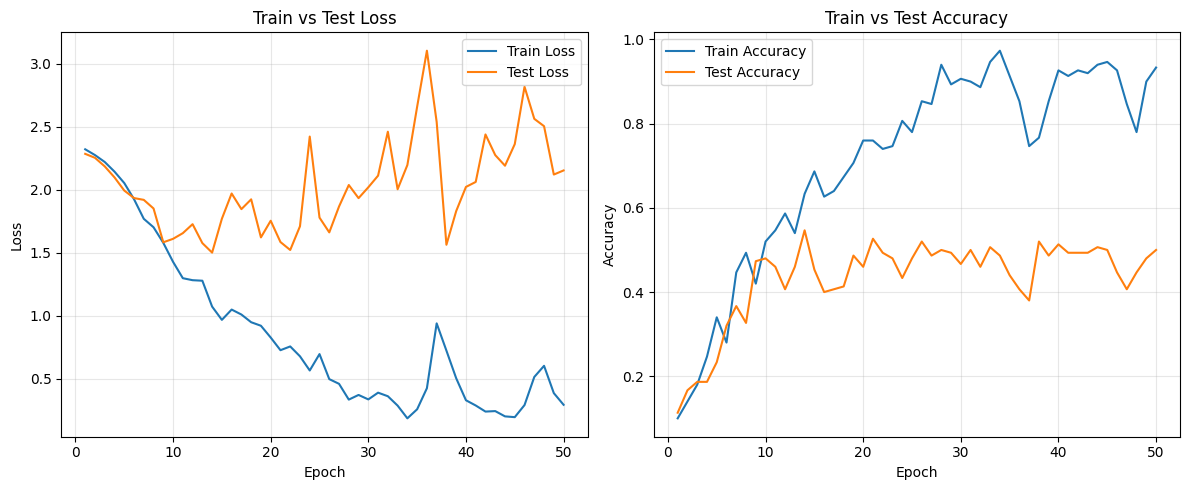

In [26]:
EPOCHS = 50
writer = SummaryWriter(log_dir=f"runs/WeightDecay_5-2_CNN")

simple_cnn = SimpleCNN(weight_decay=0.05)
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Baaaaaad

___

Dropout (2D for conv layers -> zeroes entire channels, not indivudual pixels to preserve spatial coherence)

1. First with small probability (p=0.1)

In [27]:
class DropoutCNN(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0, p=0):
        self.p = p
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Dropout2d(p=self.p),
            nn.Conv2d(6, 16, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Dropout2d(p=self.p),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Dropout(p=self.p),
            nn.Linear(84, 10)
        )

100%|██████████| 20/20 [01:04<00:00,  3.21s/epoch]


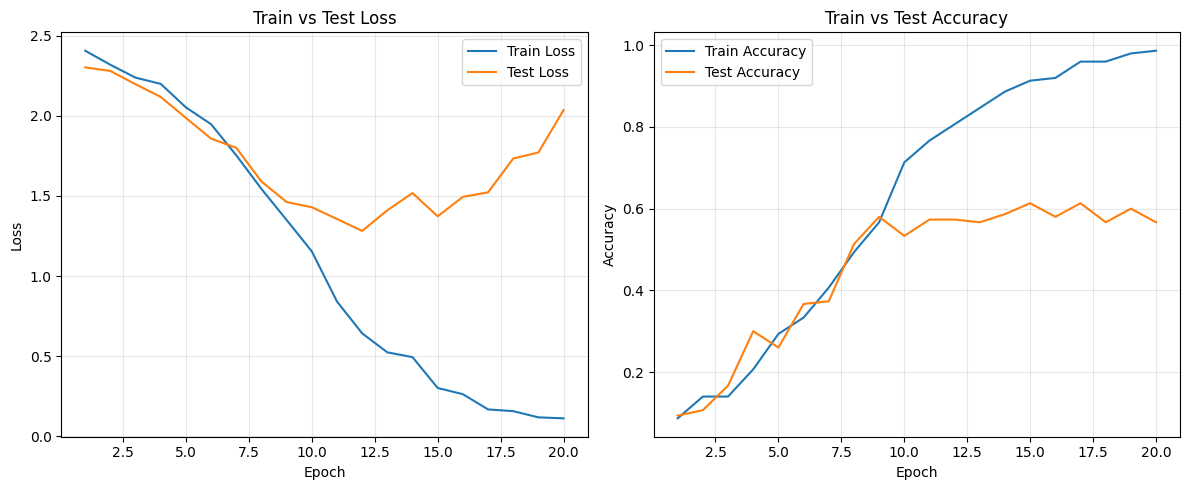

In [28]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/Dropout_1_CNN")

classifier = DropoutCNN(p=.1)
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

✅ Slight regularization effect

2. Higher probability (p=0.3)

100%|██████████| 50/50 [02:36<00:00,  3.14s/epoch]


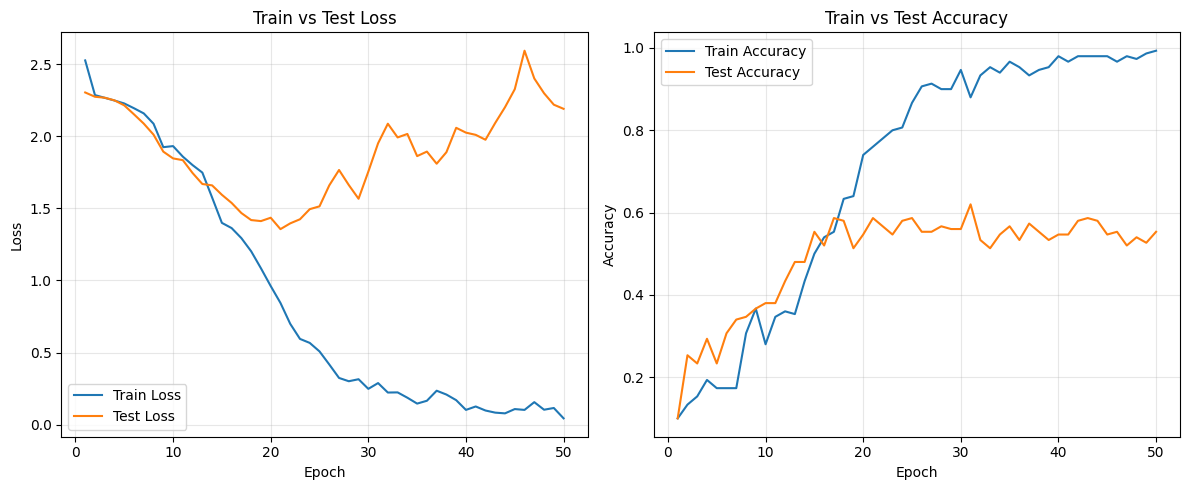

In [29]:
EPOCHS = 50
writer = SummaryWriter(log_dir=f"runs/Dropout_3_CNN")

classifier = DropoutCNN(p=.3)
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Only makes training harder, does not improve test accuracy

___

Squared Hinge Loss (why not)

In [30]:
class MultiClassSquaredHingeLoss(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, outputs, labels):
        """
        outputs: [batch_size, num_classes] - raw logits from the model (no softmax)
        labels: [batch_size] - ground truth class indices
        """
        batch_size, num_classes = outputs.size()

        # Get scores for the true classes, shape: [batch_size, 1]
        true_class_scores = outputs[torch.arange(batch_size), labels].unsqueeze(1)

        # Compute margin for all classes: (score_j - score_true + 1)
        margins = outputs - true_class_scores + 1

        # Do not consider correct classes in loss
        margins[torch.arange(batch_size), labels] = 0

        # Clamp negative margins to zero and square them
        loss = torch.clamp(margins, min=0) ** 2

        # Sum over classes and average over batch
        return loss.sum(dim=1).mean()
    

100%|██████████| 20/20 [01:02<00:00,  3.14s/epoch]


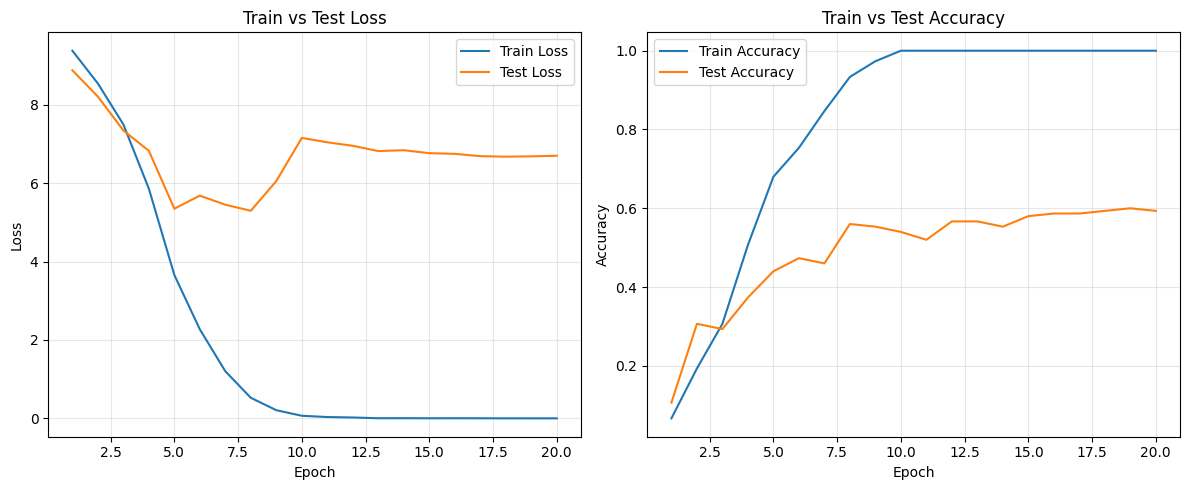

In [31]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/SqHLossCNN")

simple_cnn = SimpleCNN(criterion=MultiClassSquaredHingeLoss())
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Works similarly, no big difference I guess, maybe works better than CCE with regularization ? 🤷‍♂️

___

Truncated SVD

Don't really understand what is expected here
- Perform truncated SVD on the linear layers weight matrixes after training ? See how changing k reduces the #params and the accuracy ? 

___

Change the learning rate

1. $\lambda = 0.1$

100%|██████████| 20/20 [01:06<00:00,  3.32s/epoch]


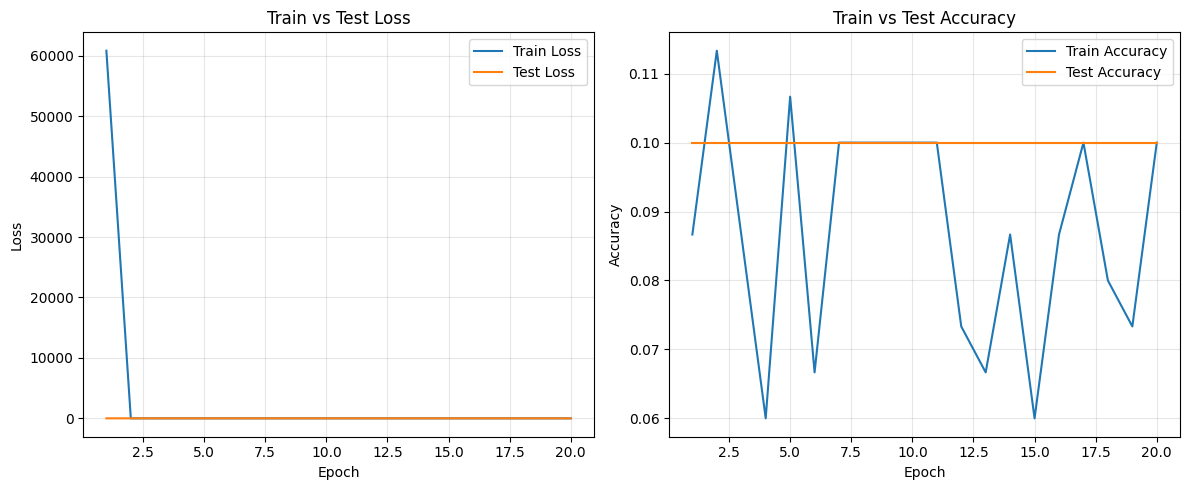

In [32]:
EPOCHS = 20
lr = 1e-1
writer = SummaryWriter(log_dir=f"runs/SimpleCNN_lr_-1")

simple_cnn = SimpleCNN(lr=lr)
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Completely diverging

2. $\lambda = 0.01$

100%|██████████| 20/20 [01:04<00:00,  3.23s/epoch]


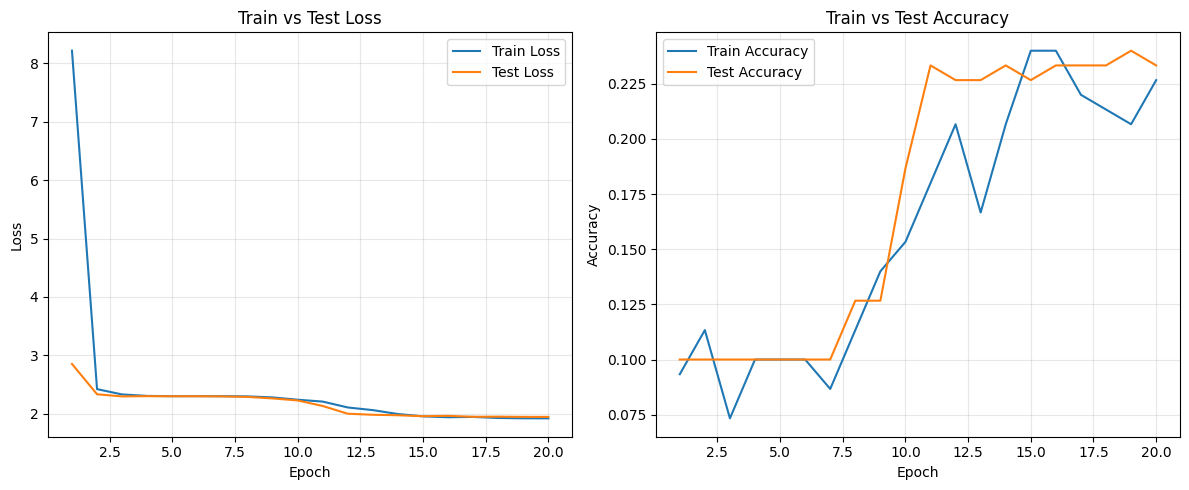

In [33]:
EPOCHS = 20
lr = 1e-2
writer = SummaryWriter(log_dir=f"runs/SimpleCNN_lr_-2")

simple_cnn = SimpleCNN(lr=lr)
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Training seems less stable

3. $\lambda = 0.0001$

100%|██████████| 30/30 [01:34<00:00,  3.14s/epoch]


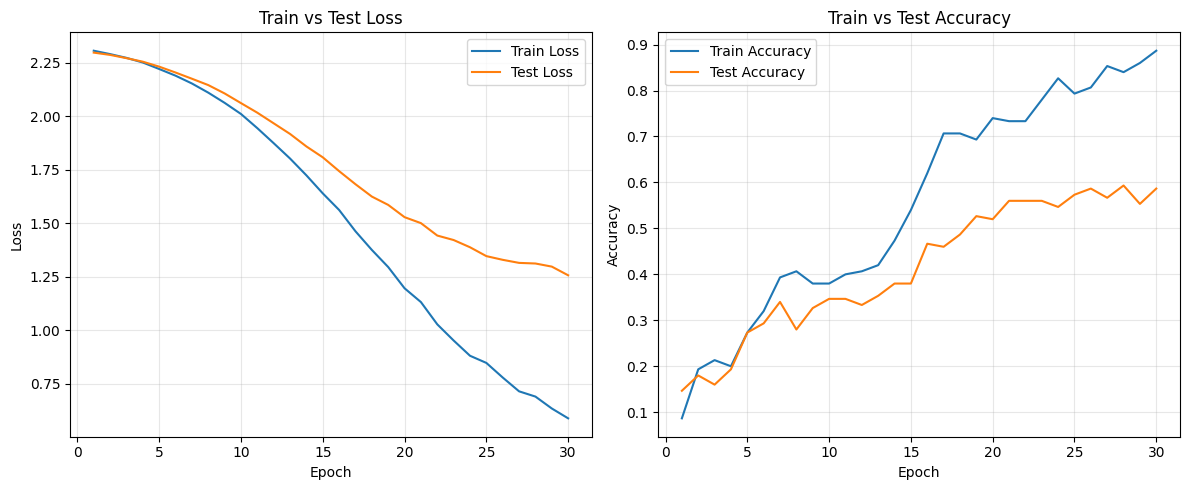

In [34]:
EPOCHS = 30
lr = 1e-4
writer = SummaryWriter(log_dir=f"runs/SimpleCNN_lr_-4")

simple_cnn = SimpleCNN(lr=lr)
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Training is longer, but very stable

___

Finetuning !! 🔥

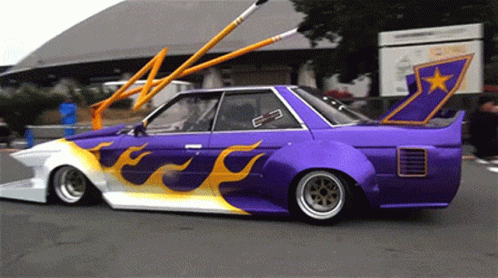

ResNet

In [45]:
import torchvision.models as models

class ResNet(BaseClassifier):

    def __init__(self, criterion=None, lr=0.001, weight_decay=0, trainable_layers=None):
        self.trainable_layers = trainable_layers
        super().__init__(criterion, lr, weight_decay)

    def build_model(self):

        model = models.resnet18(weights='DEFAULT')
        model.fc = nn.Linear(model.fc.in_features, 10)

        for param in model.parameters(): # Freeze all layers
                param.requires_grad = False

        for param in model.fc.parameters(): # Unfreeze last layer
                param.requires_grad = True

        if self.trainable_layers:
    
            for name, child in model.named_children(): # Unfreeze chosen layers
                if name in self.trainable_layers:
                    for param in child.parameters():
                        param.requires_grad = True

        return model

1. No freezing = train all parameters

100%|██████████| 20/20 [04:01<00:00, 12.06s/epoch]


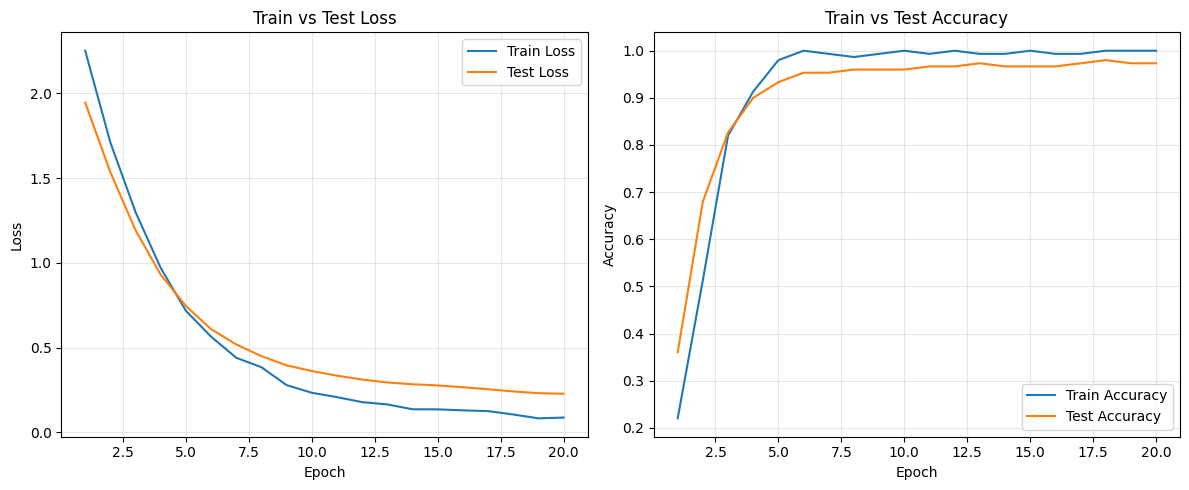

In [46]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/ResNet_Full")

resnet = ResNet()
metrics = resnet.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

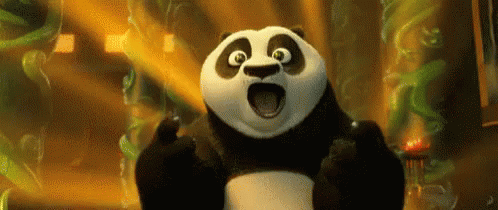

2. Freeze everything (train only the output layer)

100%|██████████| 20/20 [03:55<00:00, 11.78s/epoch]


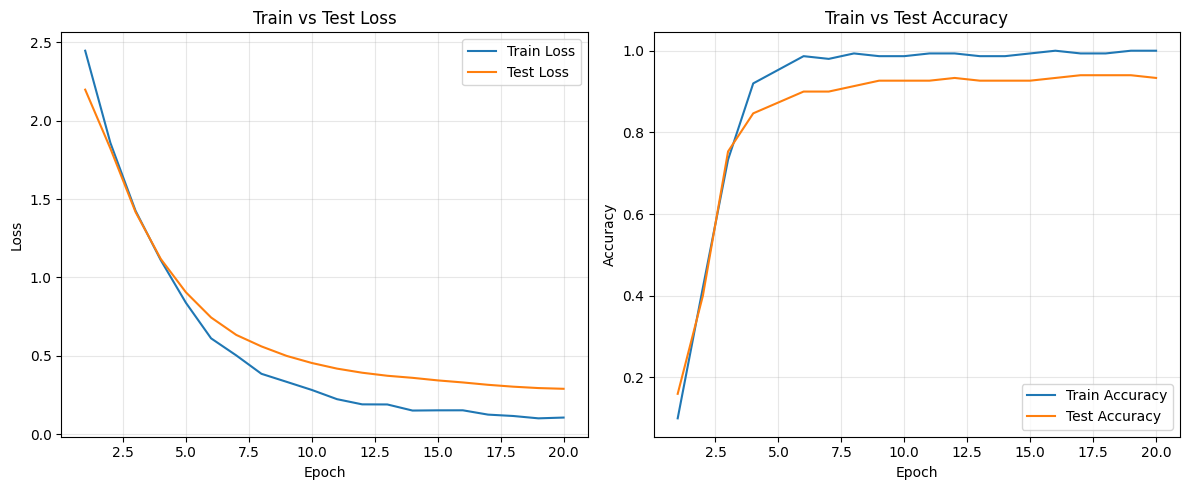

In [47]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/ResNet_OutLayer")

resnet = ResNet(trainable_layers=[])
metrics = resnet.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

Quite similar, slightly worse asymptotic accuracy

3. Train the last block + the output layer

100%|██████████| 20/20 [04:24<00:00, 13.22s/epoch]


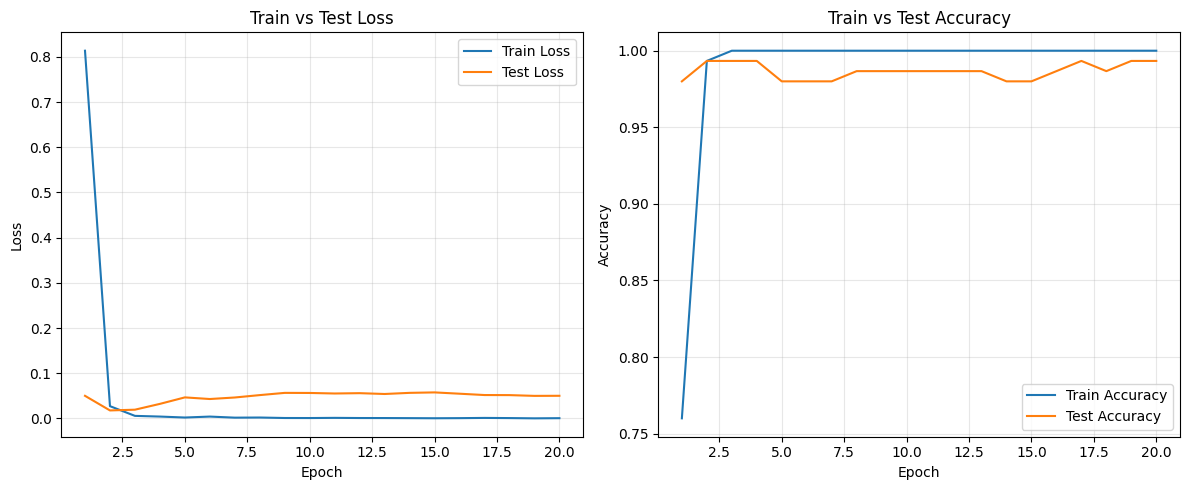

In [49]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/ResNet_Layer4")

resnet = ResNet(trainable_layers=['layer4'])
metrics = resnet.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

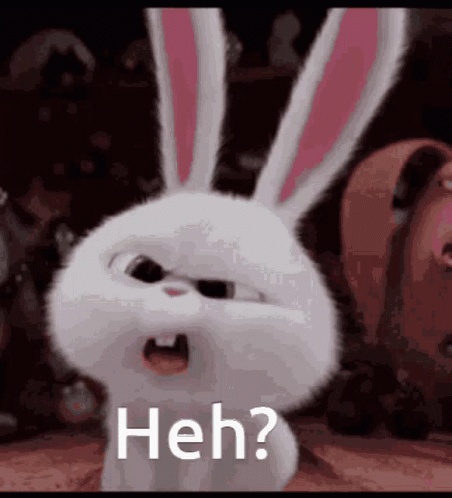